Deconvolution Microscopy (All Channels)
=======================================

This example partially replicates a [GlobalBioIm
example](https://biomedical-imaging-group.github.io/GlobalBioIm/examples.html)
using the [microscopy data](http://bigwww.epfl.ch/deconvolution/bio/)
provided by the EPFL Biomedical Imaging Group.

The deconvolution problem is solved using class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve
an image deconvolution problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; \| M (\mathbf{y} - A \mathbf{x})
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} +
  \iota_{\mathrm{NN}}(\mathbf{x}) \;,$$

where $M$ is a mask operator, $A$ is circular convolution,
$\mathbf{y}$ is the blurred image, $C$ is a convolutional gradient
operator, $\iota_{\mathrm{NN}}$ is the indicator function of the
non-negativity constraint, and $\mathbf{x}$ is the desired image.

In [1]:
import glob
import os
import tempfile
import zipfile

import numpy as np

import jax

import imageio

try:
    import ray
except ImportError:
    raise RuntimeError("The ray package is required to run this script")

import scico.numpy as snp
from scico import functional, linop, loss, plot, util
from scico.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Define helper functions.

In [2]:
def volume_read(path, ext="tif"):
    """Read a 3D volume from a set of files in the specified directory."""

    slices = []
    for file in sorted(glob.glob(os.path.join(path, "*." + ext))):
        image = imageio.imread(file)
        slices.append(image)
    return np.dstack(slices)


def get_deconv_data(channel, cache_path=None):
    """Get deconvolution problem data from EPFL Biomedical Imaging Group."""

    # data source URL and filenames
    data_base_url = "http://bigwww.epfl.ch/deconvolution/bio/"
    data_zip_files = ["CElegans-CY3.zip", "CElegans-DAPI.zip", "CElegans-FITC.zip"]
    psf_zip_files = ["PSF-" + data for data in data_zip_files]
    # set default cache path if not specified
    if cache_path is None:
        cache_path = os.path.join(os.path.expanduser("~"), ".cache", "scico", "epfl_big")

    # if cache path exists, data is assumed to aleady be downloaded
    if not os.path.isdir(cache_path):
        os.makedirs(cache_path)
        # temporary directory for downloads
        temp_dir = tempfile.TemporaryDirectory()
        # download data and psf files for selected channel into temporary directory
        for zip_file in (data_zip_files[channel], psf_zip_files[channel]):
            data = util.url_get(data_base_url + zip_file)
            f = open(os.path.join(temp_dir.name, zip_file), "wb")
            f.write(data.read())
            f.close()
        # unzip downloaded data into cache path
        for zip_file in (data_zip_files[channel], psf_zip_files[channel]):
            with zipfile.ZipFile(os.path.join(temp_dir.name, zip_file), "r") as zip_ref:
                zip_ref.extractall(cache_path)

    # read unzipped data files into 3D arrays
    zip_file = data_zip_files[channel]
    y = volume_read(os.path.join(cache_path, zip_file[:-4])).astype(np.float32)
    zip_file = psf_zip_files[channel]
    psf = volume_read(os.path.join(cache_path, zip_file[:-4])).astype(np.float32)
    return y, psf


def block_avg(im, N):
    """Average distinct NxNxN blocks of im, return the resulting smaller image."""

    im = snp.mean(snp.reshape(im, (-1, N, im.shape[1], im.shape[2])), axis=1)
    im = snp.mean(snp.reshape(im, (im.shape[0], -1, N, im.shape[2])), axis=2)
    im = snp.mean(snp.reshape(im, (im.shape[0], im.shape[1], -1, N)), axis=3)

    return im

Get and preprocess data. We downsample the data for the purposes of
the example. Reducing the downsampling rate will be slower and more
memory-intensive. If your GPU does not have enough memory, you can try
setting the environment variable `JAX_PLATFORM_NAME=cpu` to run on CPU.
To run this example on a GPU it
[may also be necessary](https://github.com/google/jax/issues/5380) to
set environment variable `XLA_PYTHON_CLIENT_PREALLOCATE=false`.

In [3]:
downsampling_rate = 4

y_list = []
y_pad_list = []
psf_list = []
for channel in range(3):
    y, psf = get_deconv_data(channel)  # get data
    y = block_avg(y, downsampling_rate)  # downsample
    psf = block_avg(psf, downsampling_rate)
    y -= y.min()  # normalize y
    y /= y.max()
    psf /= psf.sum()  # normalize psf
    if channel == 0:
        padding = [[0, p] for p in snp.array(psf.shape) - 1]
        mask = snp.pad(snp.ones_like(y), padding)
    y_pad = snp.pad(y, padding)  # zero-padded version of y
    y_list.append(y)
    y_pad_list.append(y_pad)
    psf_list.append(psf)
y = snp.stack(y_list, axis=-1)
yshape = y.shape
del y_list

Define problem and algorithm parameters.

In [4]:
λ = 2e-6  # ℓ1 norm regularization parameter
ρ0 = 1e-3  # ADMM penalty parameter for first auxiliary variable
ρ1 = 1e-3  # ADMM penalty parameter for second auxiliary variable
ρ2 = 1e-3  # ADMM penalty parameter for third auxiliary variable
maxiter = 100  # number of ADMM iterations

Initialize ray, determine available computing resources, and put large arrays
in object store.

In [5]:
ray.init()

ngpu = 0
ar = ray.available_resources()
ncpu = int(ar["CPU"]) // 3
if "GPU" in ar:
    ngpu = int(ar["GPU"]) // 3
print(f"Running on {ncpu} CPUs and {ngpu} GPUs per process")

y_pad_list = ray.put(y_pad_list)
psf_list = ray.put(psf_list)
mask_store = ray.put(mask)

Running on 26 CPUs and 2 GPUs per process


Define ray remote function for parallel solves.

In [6]:
@ray.remote(num_cpus=ncpu, num_gpus=ngpu)
def deconvolve_channel(channel):
    y_pad = jax.device_put(ray.get(y_pad_list)[channel])
    psf = jax.device_put(ray.get(psf_list)[channel])
    mask = jax.device_put(ray.get(mask_store))
    M = linop.Diagonal(mask)
    C0 = linop.CircularConvolve(
        h=psf, input_shape=mask.shape, h_center=snp.array(psf.shape) / 2 - 0.5  # forward operator
    )
    C1 = linop.FiniteDifference(input_shape=mask.shape, circular=True)  # gradient operator
    C2 = linop.Identity(mask.shape)  # identity operator
    g0 = loss.SquaredL2Loss(y=y_pad, A=M)  # loss function (forward model)
    g1 = λ * functional.L21Norm()  # TV penalty (when applied to gradient)
    g2 = functional.NonNegativeIndicator()  # non-negativity constraint
    if channel == 0:
        print("Displaying solver status for channel 0")
        verbose = True
    else:
        verbose = False
    solver = ADMM(
        f=None,
        g_list=[g0, g1, g2],
        C_list=[C0, C1, C2],
        rho_list=[ρ0, ρ1, ρ2],
        maxiter=maxiter,
        verbose=verbose,
        x0=y_pad,
        subproblem_solver=CircularConvolveSolver(),
    )
    x_pad = solver.solve()
    x = x_pad[: yshape[0], : yshape[1], : yshape[2]]
    return (x, solver.itstat_object.history(transpose=True))

Solve problems for all three channels in parallel and extract results.

In [7]:
ray_return = ray.get([deconvolve_channel.remote(channel) for channel in range(3)])
x = snp.stack([t[0] for t in ray_return], axis=-1)
solve_stats = [t[1] for t in ray_return]

(deconvolve_channel pid=22057) Displaying solver status for channel 0


(deconvolve_channel pid=22057) Iter  Time      Objective  Primal Rsdl  Dual Rsdl
(deconvolve_channel pid=22057) -------------------------------------------------
(deconvolve_channel pid=22057)    0  2.59e+00  6.897e-02    1.059e+02  7.430e+01
(deconvolve_channel pid=22057)    1  4.49e+00  8.898e-02    5.572e+01  8.752e+01
(deconvolve_channel pid=22057)    2  4.55e+00  1.058e-01    5.023e+01  7.186e+01


(deconvolve_channel pid=22057)    3  4.60e+00  1.189e-01    6.156e+01  4.522e+01
(deconvolve_channel pid=22057)    4  4.65e+00  1.333e-01    5.683e+01  3.635e+01
(deconvolve_channel pid=22057)    5  4.70e+00  1.500e-01    4.092e+01  4.393e+01
(deconvolve_channel pid=22057)    6  4.75e+00  1.661e-01    2.699e+01  4.704e+01
(deconvolve_channel pid=22057)    7  4.79e+00  1.815e-01    2.281e+01  4.420e+01


(deconvolve_channel pid=22057)    8  4.84e+00  1.964e-01    2.341e+01  4.018e+01
(deconvolve_channel pid=22057)    9  4.89e+00  2.101e-01    2.199e+01  3.820e+01
(deconvolve_channel pid=22057)   10  4.95e+00  2.219e-01    2.021e+01  3.712e+01
(deconvolve_channel pid=22057)   11  4.99e+00  2.313e-01    2.144e+01  3.495e+01


(deconvolve_channel pid=22057)   12  5.04e+00  2.383e-01    2.500e+01  3.141e+01
(deconvolve_channel pid=22057)   13  5.09e+00  2.430e-01    2.850e+01  2.733e+01
(deconvolve_channel pid=22057)   14  5.14e+00  2.459e-01    3.101e+01  2.348e+01
(deconvolve_channel pid=22057)   15  5.19e+00  2.473e-01    3.256e+01  2.014e+01
(deconvolve_channel pid=22057)   16  5.24e+00  2.475e-01    3.334e+01  1.746e+01


(deconvolve_channel pid=22057)   17  5.29e+00  2.468e-01    3.339e+01  1.576e+01
(deconvolve_channel pid=22057)   18  5.34e+00  2.456e-01    3.270e+01  1.544e+01
(deconvolve_channel pid=22057)   19  5.39e+00  2.438e-01    3.133e+01  1.642e+01
(deconvolve_channel pid=22057)   20  5.43e+00  2.419e-01    2.942e+01  1.812e+01


(deconvolve_channel pid=22057)   21  5.48e+00  2.399e-01    2.710e+01  2.007e+01
(deconvolve_channel pid=22057)   22  5.55e+00  2.381e-01    2.446e+01  2.196e+01
(deconvolve_channel pid=22057)   23  5.59e+00  2.366e-01    2.162e+01  2.365e+01
(deconvolve_channel pid=22057)   24  5.64e+00  2.356e-01    1.874e+01  2.500e+01
(deconvolve_channel pid=22057)   25  5.69e+00  2.353e-01    1.608e+01  2.590e+01


(deconvolve_channel pid=22057)   26  5.74e+00  2.359e-01    1.399e+01  2.629e+01
(deconvolve_channel pid=22057)   27  5.79e+00  2.376e-01    1.286e+01  2.615e+01
(deconvolve_channel pid=22057)   28  5.84e+00  2.401e-01    1.291e+01  2.548e+01
(deconvolve_channel pid=22057)   29  5.89e+00  2.433e-01    1.401e+01  2.429e+01


(deconvolve_channel pid=22057)   30  5.95e+00  2.470e-01    1.580e+01  2.253e+01
(deconvolve_channel pid=22057)   31  6.00e+00  2.508e-01    1.770e+01  2.041e+01
(deconvolve_channel pid=22057)   32  6.06e+00  2.546e-01    1.920e+01  1.824e+01
(deconvolve_channel pid=22057)   33  6.10e+00  2.585e-01    2.035e+01  1.608e+01
(deconvolve_channel pid=22057)   34  6.15e+00  2.624e-01    2.119e+01  1.411e+01


(deconvolve_channel pid=22057)   35  6.19e+00  2.663e-01    2.167e+01  1.255e+01
(deconvolve_channel pid=22057)   36  6.24e+00  2.701e-01    2.182e+01  1.151e+01
(deconvolve_channel pid=22057)   37  6.29e+00  2.740e-01    2.166e+01  1.100e+01
(deconvolve_channel pid=22057)   38  6.33e+00  2.780e-01    2.120e+01  1.103e+01
(deconvolve_channel pid=22057)   39  6.38e+00  2.820e-01    2.044e+01  1.159e+01


(deconvolve_channel pid=22057)   40  6.43e+00  2.861e-01    1.935e+01  1.260e+01
(deconvolve_channel pid=22057)   41  6.47e+00  2.901e-01    1.795e+01  1.383e+01
(deconvolve_channel pid=22057)   42  6.52e+00  2.939e-01    1.632e+01  1.509e+01
(deconvolve_channel pid=22057)   43  6.56e+00  2.973e-01    1.457e+01  1.623e+01


(deconvolve_channel pid=22057)   44  6.61e+00  3.005e-01    1.286e+01  1.713e+01
(deconvolve_channel pid=22057)   45  6.66e+00  3.034e-01    1.141e+01  1.771e+01
(deconvolve_channel pid=22057)   46  6.71e+00  3.061e-01    1.046e+01  1.793e+01
(deconvolve_channel pid=22057)   47  6.76e+00  3.085e-01    1.016e+01  1.780e+01
(deconvolve_channel pid=22057)   48  6.81e+00  3.108e-01    1.053e+01  1.733e+01


(deconvolve_channel pid=22057)   49  6.85e+00  3.129e-01    1.140e+01  1.656e+01
(deconvolve_channel pid=22057)   50  6.90e+00  3.150e-01    1.252e+01  1.554e+01
(deconvolve_channel pid=22057)   51  6.95e+00  3.169e-01    1.369e+01  1.433e+01
(deconvolve_channel pid=22057)   52  7.00e+00  3.189e-01    1.477e+01  1.302e+01
(deconvolve_channel pid=22057)   53  7.05e+00  3.210e-01    1.565e+01  1.172e+01


(deconvolve_channel pid=22057)   54  7.09e+00  3.233e-01    1.627e+01  1.055e+01
(deconvolve_channel pid=22057)   55  7.14e+00  3.257e-01    1.661e+01  9.649e+00
(deconvolve_channel pid=22057)   56  7.19e+00  3.283e-01    1.664e+01  9.158e+00
(deconvolve_channel pid=22057)   57  7.24e+00  3.312e-01    1.637e+01  9.151e+00


(deconvolve_channel pid=22057)   58  7.29e+00  3.342e-01    1.582e+01  9.582e+00
(deconvolve_channel pid=22057)   59  7.33e+00  3.375e-01    1.502e+01  1.030e+01
(deconvolve_channel pid=22057)   60  7.38e+00  3.409e-01    1.403e+01  1.115e+01
(deconvolve_channel pid=22057)   61  7.44e+00  3.445e-01    1.291e+01  1.199e+01
(deconvolve_channel pid=22057)   62  7.48e+00  3.482e-01    1.175e+01  1.273e+01


(deconvolve_channel pid=22057)   63  7.53e+00  3.518e-01    1.065e+01  1.331e+01
(deconvolve_channel pid=22057)   64  7.58e+00  3.554e-01    9.719e+00  1.370e+01
(deconvolve_channel pid=22057)   65  7.63e+00  3.589e-01    9.067e+00  1.386e+01
(deconvolve_channel pid=22057)   66  7.68e+00  3.623e-01    8.775e+00  1.379e+01
(deconvolve_channel pid=22057)   67  7.73e+00  3.655e-01    8.847e+00  1.350e+01


(deconvolve_channel pid=22057)   68  7.77e+00  3.686e-01    9.209e+00  1.304e+01
(deconvolve_channel pid=22057)   69  7.83e+00  3.714e-01    9.738e+00  1.246e+01
(deconvolve_channel pid=22057)   70  7.88e+00  3.740e-01    1.032e+01  1.179e+01
(deconvolve_channel pid=22057)   71  7.93e+00  3.764e-01    1.087e+01  1.108e+01


(deconvolve_channel pid=22057)   72  7.97e+00  3.788e-01    1.134e+01  1.036e+01
(deconvolve_channel pid=22057)   73  8.02e+00  3.811e-01    1.170e+01  9.708e+00
(deconvolve_channel pid=22057)   74  8.06e+00  3.835e-01    1.191e+01  9.184e+00
(deconvolve_channel pid=22057)   75  8.12e+00  3.858e-01    1.196e+01  8.836e+00
(deconvolve_channel pid=22057)   76  8.18e+00  3.882e-01    1.186e+01  8.687e+00


(deconvolve_channel pid=22057)   77  8.23e+00  3.907e-01    1.161e+01  8.723e+00
(deconvolve_channel pid=22057)   78  8.28e+00  3.933e-01    1.122e+01  8.922e+00
(deconvolve_channel pid=22057)   79  8.32e+00  3.960e-01    1.072e+01  9.238e+00
(deconvolve_channel pid=22057)   80  8.37e+00  3.988e-01    1.012e+01  9.620e+00
(deconvolve_channel pid=22057)   81  8.41e+00  4.016e-01    9.469e+00  1.001e+01


(deconvolve_channel pid=22057)   82  8.46e+00  4.045e-01    8.811e+00  1.037e+01
(deconvolve_channel pid=22057)   83  8.51e+00  4.075e-01    8.201e+00  1.065e+01
(deconvolve_channel pid=22057)   84  8.55e+00  4.104e-01    7.695e+00  1.085e+01
(deconvolve_channel pid=22057)   85  8.60e+00  4.134e-01    7.347e+00  1.093e+01


(deconvolve_channel pid=22057)   86  8.65e+00  4.164e-01    7.189e+00  1.089e+01
(deconvolve_channel pid=22057)   87  8.70e+00  4.193e-01    7.223e+00  1.074e+01
(deconvolve_channel pid=22057)   88  8.75e+00  4.223e-01    7.416e+00  1.050e+01
(deconvolve_channel pid=22057)   89  8.79e+00  4.252e-01    7.718e+00  1.018e+01
(deconvolve_channel pid=22057)   90  8.85e+00  4.282e-01    8.070e+00  9.803e+00


(deconvolve_channel pid=22057)   91  8.89e+00  4.311e-01    8.421e+00  9.407e+00
(deconvolve_channel pid=22057)   92  8.93e+00  4.341e-01    8.728e+00  9.019e+00
(deconvolve_channel pid=22057)   93  8.98e+00  4.370e-01    8.964e+00  8.667e+00
(deconvolve_channel pid=22057)   94  9.02e+00  4.400e-01    9.108e+00  8.381e+00
(deconvolve_channel pid=22057)   95  9.07e+00  4.430e-01    9.152e+00  8.185e+00


(deconvolve_channel pid=22057)   96  9.12e+00  4.460e-01    9.096e+00  8.087e+00
(deconvolve_channel pid=22057)   97  9.17e+00  4.490e-01    8.946e+00  8.083e+00
(deconvolve_channel pid=22057)   98  9.22e+00  4.520e-01    8.718e+00  8.160e+00
(deconvolve_channel pid=22057)   99  9.27e+00  4.550e-01    8.431e+00  8.293e+00


Show the recovered image.

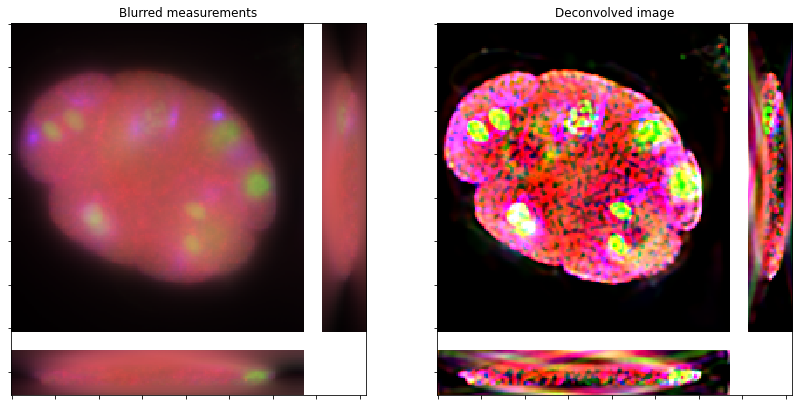

In [8]:
def make_slices(x, sep_width=10):
    """Make an image with xy, xz, and yz slices from an input volume."""

    fill_val = -1.0
    out = snp.concatenate(
        (
            x[:, :, x.shape[2] // 2],
            snp.full((x.shape[0], sep_width, 3), fill_val),
            x[:, x.shape[1] // 2, :],
        ),
        axis=1,
    )

    out = snp.concatenate(
        (
            out,
            snp.full((sep_width, out.shape[1], 3), fill_val),
            snp.concatenate(
                (
                    x[x.shape[0] // 2, :, :].transpose((1, 0, 2)),
                    snp.full((x.shape[2], x.shape[2] + sep_width, 3), fill_val),
                ),
                axis=1,
            ),
        ),
        axis=0,
    )

    out = snp.where(out == fill_val, out.max(), out)

    return out


fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot.imview(make_slices(y), title="Blurred measurements", fig=fig, ax=ax[0])
plot.imview(make_slices(x), title="Deconvolved image", fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

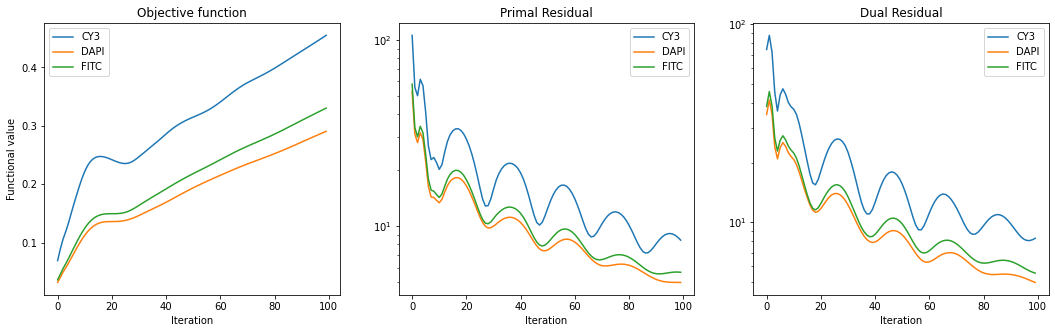

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(18, 5))
plot.plot(
    np.stack([s.Objective for s in solve_stats]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.stack([s.Primal_Rsdl for s in solve_stats]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.stack([s.Dual_Rsdl for s in solve_stats]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    lgnd=("CY3", "DAPI", "FITC"),
    fig=fig,
    ax=ax[2],
)
fig.show()